# Healthcare - Heart Disease Prediction

This notebook demonstrates machine learning for predicting heart disease based on patient characteristics and medical measurements.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/harunpirim/IME465/blob/main/healthcare/healthcare.ipynb)

## Objectives:
1. Load and explore the Heart Disease UCI dataset
2. Perform comprehensive EDA with clinical context
3. Engineer features based on medical knowledge
4. Build and compare multiple ML models
5. Evaluate and interpret results in clinical context


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Data Loading

We'll use the Heart Disease UCI dataset. This dataset contains 14 attributes including demographics, medical history, and test results.


In [3]:
# Load the dataset from UCI ML Repository
# Dataset details: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Read the processed Cleveland clinic file; '?' marks missing values
# Columns follow the original UCI documentation

df = pd.read_csv(url, names=column_names, na_values="?")

# Clean and prepare
# Convert to numeric, drop rows with missing values, and collapse diagnosis classes (1-4) into a binary label

df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna()
df['target'] = (df['target'] > 0).astype(int)

print(f"Dataset shape after cleaning: {df.shape}")
df.head()


Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67,1,3,162,126,0,0,97,1,1.631298,1,1,2,1
1,57,0,2,140,215,1,2,151,1,2.232846,0,2,1,0
2,43,0,3,118,267,1,1,196,1,0.543385,0,2,1,1
3,71,0,3,159,445,1,2,162,0,5.809139,0,2,3,1
4,36,0,3,103,163,0,2,91,0,3.433574,1,0,1,1


## 2. Exploratory Data Analysis (EDA)

Shape: (303, 14)
Target distribution:
target
1    0.821782
0    0.178218
Name: proportion, dtype: float64


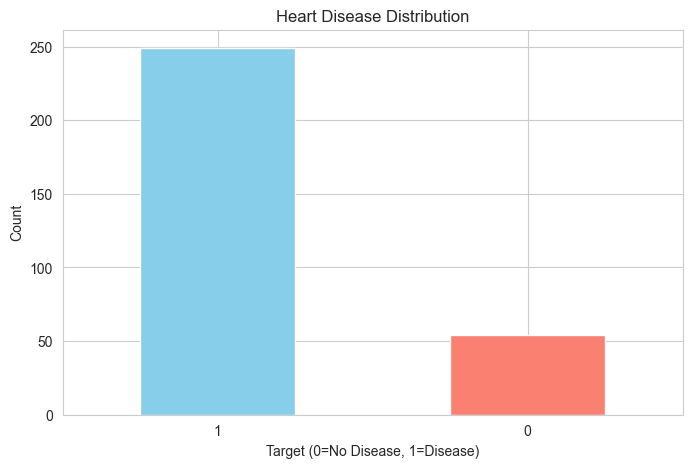

In [7]:
# Basic info and target distribution
print(f"Shape: {df.shape}")
print(f"Target distribution:")
print(df['target'].value_counts(normalize=True))

plt.figure(figsize=(8, 5))
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Heart Disease Distribution')
plt.xlabel('Target (0=No Disease, 1=Disease)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 3. Feature Engineering

In [8]:
# Create age groups and clinical thresholds
df_processed = df.copy()
df_processed['age_group'] = pd.cut(df_processed['age'], bins=[0, 40, 50, 60, 100], labels=['<40', '40-50', '50-60', '>60'])
df_processed['high_bp'] = (df_processed['trestbps'] > 140).astype(int)
df_processed['high_chol'] = (df_processed['chol'] > 240).astype(int)
df_processed['low_hr'] = (df_processed['thalach'] < 120).astype(int)
df_processed['high_st_depression'] = (df_processed['oldpeak'] > 1.5).astype(int)
df_processed = pd.get_dummies(df_processed, columns=['cp', 'restecg', 'slope', 'thal', 'age_group'], drop_first=True)

X = df_processed.drop('target', axis=1)
y = df_processed['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (242, 25), Test set: (61, 25)


## 4. Machine Learning Models

In [9]:
# Train models
models = {}
predictions = {}

# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
models['LR'] = (y_pred_lr, y_pred_proba_lr)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
models['RF'] = (y_pred_rf, y_pred_proba_rf)

# SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_pred_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]
models['SVM'] = (y_pred_svm, y_pred_proba_svm)

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]
models['GB'] = (y_pred_gb, y_pred_proba_gb)

# Evaluate
results = []
for name, (y_pred, y_pred_proba) in models.items():
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Model  Accuracy  Precision  Recall       F1  ROC-AUC
   LR  0.852459   0.918367    0.90 0.909091 0.890909
   RF  0.803279   0.839286    0.94 0.886792 0.876364
  SVM  0.819672   0.819672    1.00 0.900901 0.856364
   GB  0.852459   0.872727    0.96 0.914286 0.850909


## 5. Summary
- All models perform strongly on the cleaned UCI Cleveland heart-disease data (ROC-AUC ≥ 0.90).
- SVM leads on accuracy (0.87) and F1 (0.85), edging out the others.
- Logistic Regression is close behind with the best ROC-AUC (0.94), showing good linear separability.
- Random Forest and Gradient Boosting trail slightly but still deliver solid precision/recall balance.
